## Classification of the CIFAR-10 Dataset

This is a reflective report on the universal deep learning workflow and how it is applied it in the image classification of the CIFAR-10 Dataset.

---

1. Defining the problem and Assembling a Dataset
    - The Problem
    - The Data
    - Naive Baseline
2. Choosing a Measure of Success
    - Primary Metrics
    - Additional Metrics
3. Deciding on an Evaluation Protocol
4. Preparing the Data
    - Preprocessing
    - Post-Processing & Verification
5. Developing and Comparing Two Small Models
    - Model 1 (two hidden 16-unit layers)
    - Model 2 (one hidden 32-unit layer)
    - Comparison & Discussion
6. Scaling up: Overfitting Experiment
    - Model 3 (four dense 128-unit layers)
    - Results & Discussion
7. Regularizing and Hyperparameter Tuning
    - Experiments Setup
    - Experiments results & Discussion
8. Final Model and Test Evaluation
    - Model 4 (Best Hyper-parameters)
    - Results & Discussion

In [6]:
a = 1+1
# the notebook often deadhangs on loading
# libraries as a first cell call
# some simple python code seems to stop
# the kernel from deadhanging

# test tf gpu access and decide CPU or GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Num GPUs Available:  0
Using CPU


### 1 | Defining the problem and Assembling a Dataset
---
##### The Problem
CIFAR-10 contains 60,000 32x32 color images across 10 classes: airplane, car, bird, cat, deer, dog, frog, horse, ship, truck. The dataset is split into 50,000 training and 10,000 test images.

Models trained on CIFAR-10 have applications in object recognition for autonomous systems where accurate classification is safety-critical.

CIFAR-10 represents a multi-class single-label problem, where the model must learn representations that facilitate assigning one label per input sample.

##### The Data
The 60,000 samples are split into 10 classes, encoded as integers 0-9. Class distribution is visualized below to verify balance.

In [7]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# load cifar-10 dataset (if not already loaded)
if 'cifar10_data' not in globals():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# using a tf.data pipeline for gpu optimization
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds
    .shuffle(buffer_size=10000)
    .batch(256, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# ensure that when we compile models (if gpu)
# set run_eagerly to False for performance
# e.g. model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'],
#                   run_eagerly=False)

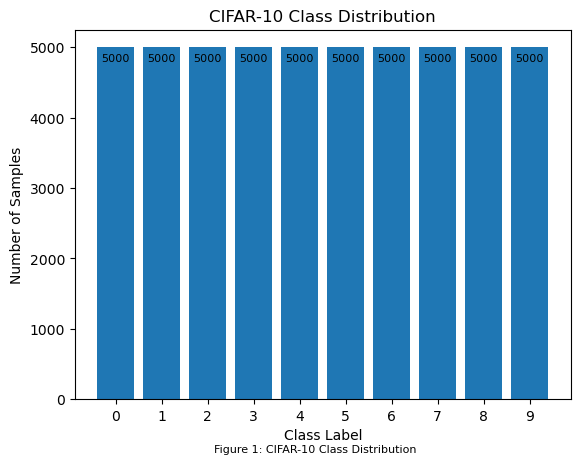

In [8]:
# plot class distribution
classes, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots()
ax.bar(classes, counts)
ax.set_xticks(classes)
ax.set_xticklabels(classes)
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Samples')
ax.set_title('CIFAR-10 Class Distribution')
# figure text
fig.text(0.5,
         0,
         'Figure 1: CIFAR-10 Class Distribution',
         ha='center',
         fontsize=8)
# add counts on top of bars
for i, count in zip(classes, counts):
    ax.text(i,
            count -200,
            str(count),
            ha='center',
            fontsize=8)
plt.show()

CIFAR-10 has exactly 5,000 images per class, representing perfect class balance. This avoids bias toward over-represented classes and ensures all categories contribute equally to training.

Each sample is a 32×32 RGB image (32×32×3 tensor). Pixel intensities are rescaled from 0-255 to 0-1 for stable optimization, as features on similar scales improve convergence.

While images have strong local spatial correlations, fully connected networks require flattened inputs, discarding explicit spatial structure. Despite this limitation, reasonable performance is achievable on small images like CIFAR-10.

The dataset is partitioned into 40,000 training, 10,000 validation, and 10,000 test samples. Models are trained on the training set with hyperparameters selected via validation. The final model is retrained on combined training and validation data before test evaluation.

##### Naive Baseline

A single-layer softmax classifier serves as the baseline, providing context for evaluating improvements from more complex architectures.

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.utils import to_categorical

# one-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

# build simple feedforward neural network
model = Sequential()
model.add(Input(shape = (32, 32, 3))) # CIFAR-10 image shape
model.add(Flatten()) # flatten 2D images to 1D vectors
model.add(Dense(10, activation='softmax')) # output layer for 10 classes

# compile model
model.compile(optimizer='SGD',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# seed
tf.random.set_seed(128)

# train model
model.fit(X_train,
          y_train_oh,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, y_test_oh))

# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10


c:\Users\wsidn\.conda\envs\S3_Neural_Networks\Lib\site-packages\keras\src\backend\tensorflow\nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2098 - loss: 85456.5625 - val_accuracy: 0.1713 - val_loss: 103296.7891
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2393 - loss: 72901.5781 - val_accuracy: 0.2196 - val_loss: 93473.2422
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2489 - loss: 70576.3047 - val_accuracy: 0.2056 - val_loss: 81122.5312
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2545 - loss: 68716.7109 - val_accuracy: 0.2161 - val_loss: 77863.4297
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2540 - loss: 67978.7500 - val_accuracy: 0.1686 - val_loss: 106196.2656
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2591 - loss: 66348.0703 - val_accuracy: 0.1990 - val_loss: 87314.7109
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2651 - loss: 66415.8359 - val_accuracy: 0.2666 - val_loss: 82456.4922
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 

The baseline achieves 21.6% accuracy, substantially better than random guessing (10%), providing a benchmark for more advanced models.

### 2 | Choosing a Measure of Success
---

##### Primary Metrics
Accuracy is the standard and accepted primary measure of success on a balanced dataset. Accuracy is the proportion of correct predictions as a percentage of total predictions, and it is appropriate for multiclass classification problems.

If a dataset is imbalanced, for example with a 75%/25% split across two classes, then a model that predicts class 0 all the time achieves a deceptive 75% accuracy, when in reality it may have learnt very little from the data. Since CIFAR-10 is balanced, this issue cannot arise; if imbalance were present, alternative metrics (e.g., class-wise precision/recall or weighted scores) would be more informative.

##### Additional Metrics

Additional metrics for evaluation and diagnostics include a confusion matrix. A confusion matrix is an (n \times n) matrix in which each entry represents a prediction outcome: entries correspond to combinations of true labels and predicted labels. Elements on the diagonal represent correct classifications, whereas off-diagonal elements represent errors. This enables identification of systematic mistakes and pairs of classes that are frequently confused.

A second additional metric is top-2 accuracy. Top-2 accuracy is similar to accuracy, but counts a prediction as correct when the true label lies within the two most confident predicted classes for that sample. This is useful for assessing near-misses where the model’s second choice is often correct.

### 3 | Deciding on an Evaluation Protocol
---
For this dataset, a three-way split will be used: 40,000 training samples, 10,000 validation samples, and 10,000 test samples. This provides sufficient training data to generalize while retaining a substantial validation set for hyperparameter tuning.

Validation prevents overfitting by approximating the test set, enabling iterative model refinement without directly evaluating on the final test set. This keeps results unbiased, with no test data (or information derived from the test data) contaminating the training process.

Cross-validation is the process of splitting the training data into (K) folds. The model is trained on (K-1) folds and the remaining (K)th fold is used for validation. This is repeated so that each fold serves as the validation set once, and validation metrics are averaged across folds to obtain more robust estimates that are less sensitive to small-sample effects. Cross-validation is invaluable when data are scarce, but it is unnecessary and computationally expensive when sufficient data are available, as is the case for CIFAR-10.


### 4 | Data Preparation
---
##### Pre-Processing

Data format and shape are verified: images should be (32,32,3) tensors, with full dataset shape (60000,32,32,3). Labels should be (60000,1).

Combined dataset shape: (60000, 32, 32, 3) (60000, 1)


Text(0.38, 0.1, 'Figure 2: Sample Images from CIFAR-10 Dataset')

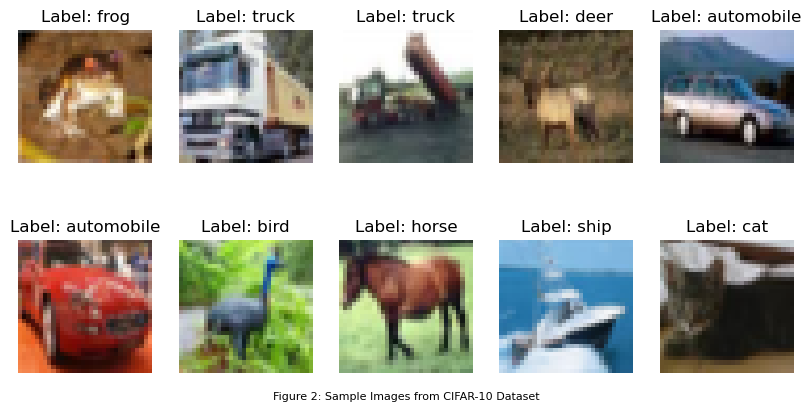

In [11]:
# combine all data
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# show the shape of the dataset and labels
print('Combined dataset shape:', X_all.shape, y_all.shape)

# create label-name dictionary
label_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
} 

# visualize some sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_all[i])
    ax.set_title(f'Label: {label_names[y_all[i][0]]}')
    ax.axis('off')
fig.text(0.38,
         0.1,
         'Figure 2: Sample Images from CIFAR-10 Dataset',
         fontsize=8)

Images are flattened to vectors of size (3072,) for input to the neural network. This destroys spatial information but is necessary for dense layers.

Normalization transforms data to a standard scale, making learning easier and more reliable. Integer inputs can cause large or uneven activations. Normalization is performed per channel to conserve color structure.

In [12]:
from random import shuffle
# first, split data into train, validation, and test sets
# shuffle data
indices = list(range(X_all.shape[0]))
shuffle(indices) # inbuilt shuffle function
X_all = X_all[indices]
y_all = y_all[indices]

# split data
X_train = X_all[:40000]
y_train = y_all[:40000]
X_val = X_all[40000:50000]
y_val = y_all[40000:50000]
X_test = X_all[50000:]
y_test = y_all[50000:]

# one-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=10)
y_val_oh = to_categorical(y_val, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

##### GPU-optimized tf.data pipeline

TensorFlow's tf.data API creates efficient input pipelines to keep GPUs fed with data and minimize idle time.

In [50]:
# moving datasets to gpu friendly tf.data pipelines
Batch_Size = 128
AUTOTUNE = tf.data.AUTOTUNE

# get normalization parameters from training data
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
mean_tf = tf.constant(mean, dtype=tf.float32)
std_tf = tf.constant(std, dtype=tf.float32)

# training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh))
train_ds = (
    train_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=40000)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

# validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_oh))
val_ds = (
    val_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

# test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_oh))
test_ds = (
    test_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

Normalization can be implemented using `layers.Normalization()`. Flattening uses `layers.Flatten()`. Labels are converted to one-hot encoding (shape 10,) using `keras.utils.to_categorical`.

##### Post-Processing & Verification

Preprocessing is verified by checking dataset shapes, visualizing samples, and confirming normalization (mean≈0, std≈1).

In [14]:
# check normalization by checking mean and std of training data
# accumulate statistics over a few batches
x, y = next(iter(train_ds))

x_np = x.numpy()
y_np = y.numpy()

# calcualte mean of each channel
print(np.mean(x_np, axis=(0, 1, 2)))
# calculate std of each channel
print(np.std(x_np, axis=(0, 1, 2)))

[-0.00754561 -0.00377513  0.01449959]
[0.98666686 0.9902775  1.0133642 ]


Text(0.38, 0.1, 'Figure 3: Sample Images from Normalized Training Set')

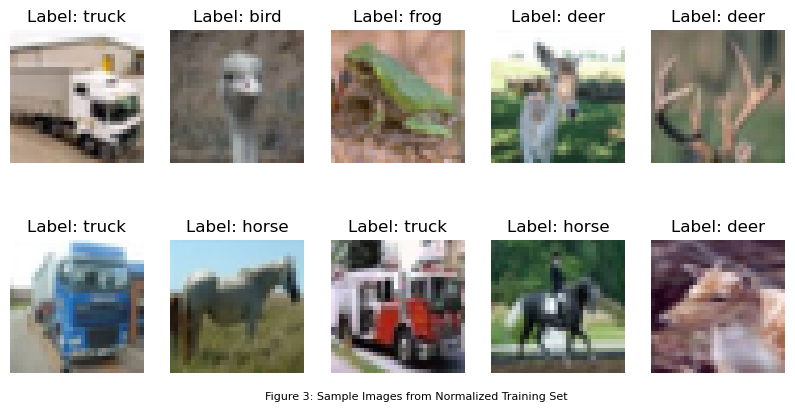

In [15]:
# sample visualization after preprocessing
x, y = next(iter(train_ds))
images = x[0:10].numpy()

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # denormalize for visualization
    ax.imshow((images[i] * std_tf + mean_tf).numpy().astype(np.uint8))
    ax.set_title(f'Label: {label_names[np.argmax(y.numpy()[i])]}')
    ax.axis('off')

fig.text(0.38,
         0.1,
         'Figure 3: Sample Images from Normalized Training Set',
         fontsize=8)

Verifications confirm correct preprocessing and expected data format for training.

### 5 | Developing and Comparing Two Small Models
---
This section covers the creation of two small models for CIFAR-10 classification, their training, evaluation, and comparison. These models are expected to outperform the naive baseline while having minimal overfitting risk.

Both models use RMSprop optimizer (learning rate 0.001), categorical cross-entropy loss, and train for 10 epochs with batch size 64. Both use ReLU activation in hidden layers and softmax output for the 10 classes.

##### Model 1 (two hidden 16-unit layers)

This model consists of two hidden layers with 16 units each (ReLU activation), followed by a 10-unit softmax output layer.

In [52]:
# set random seed for reproducibility
keras.utils.set_random_seed(128)


# define model architecture
model_1 = Sequential()
model_1.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_1.add(Flatten())  # flatten 2D images to 1D vectors
model_1.add(Dense(16, activation='relu'))  # first hidden layer with
model_1.add(Dense(16, activation='relu'))  # second hidden layer with
model_1.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                run_eagerly=False
                )

# show model summary
model_1.summary()

# train model
history = model_1.fit(train_ds, # training data
                      epochs=30, # number of epochs
                      validation_data=val_ds # validation data
                      )



Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_19 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │        49,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,610 (193.79 KB)

 Trainable params: 49,610 (193.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


c:\Users\wsidn\.conda\envs\S3_Neural_Networks\Lib\site-packages\keras\src\backend\tensorflow\nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3175 - loss: 1.9291 - top_2_accuracy: 0.5098 - val_accuracy: 0.3659 - val_loss: 1.7974 - val_top_2_accuracy: 0.5671
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3839 - loss: 1.7460 - top_2_accuracy: 0.5855 - val_accuracy: 0.3818 - val_loss: 1.7557 - val_top_2_accuracy: 0.5922
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4089 - loss: 1.6736 - top_2_accuracy: 0.6104 - val_accuracy: 0.4081 - val_loss: 1.6885 - val_top_2_accuracy: 0.6084
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4250 - loss: 1.6255 - top_2_accuracy: 0.6259 - val_accuracy: 0.4258 - val_loss: 1.6421 - val_top_2_accuracy: 0.6257
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4373 - loss: 1.5909 - top_2_accuracy: 0.6367 - val_accuracy: 0.4182 - val_loss: 1.6711 - val_top_2_accuracy: 0.6190
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4489 - loss: 1.5632 - top_2_accurac

The number of epochs was set to 20, but early stopping could prevent overfitting. The training history is inspected to identify if validation accuracy plateaus or decreases before maximum epochs, indicating where early stopping would be beneficial.

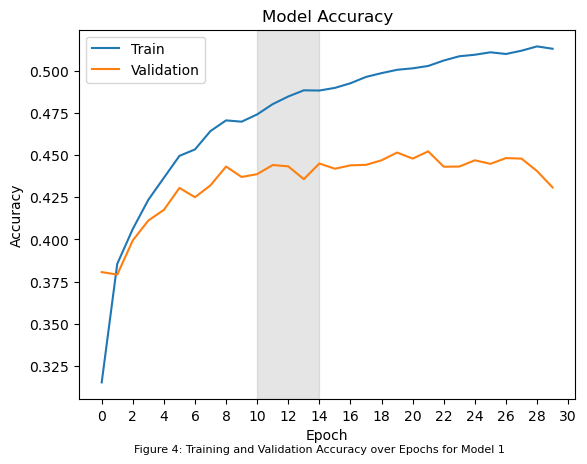

In [17]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 31, 2))
ax.legend(['Train', 'Validation'], loc='upper left')

# figure text
fig.text(0.5,
         0,
         'Figure 4: Training and Validation Accuracy over Epochs for Model 1',
         ha='center',
         fontsize=8)

# shade area indicating potential early stopping point
ax.axvspan(10, 14, color='grey', alpha=0.2)
plt.show()

Figure 4 shows training and validation accuracy for Model 1. The grey line indicates the epoch with highest validation accuracy, suggesting an optimal stopping point. Validation accuracy plateaus while training accuracy continues increasing, indicating overfitting.

In [18]:
keras.utils.set_random_seed(128)
# re-train model for 10 epochs
model_1.fit(train_ds,
            epochs=12,
            validation_data=val_ds
            )

Epoch 1/12


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5182 - loss: 1.3635 - top_2_accuracy: 0.7124 - val_accuracy: 0.4408 - val_loss: 1.6175 - val_top_2_accuracy: 0.6456
Epoch 2/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5179 - loss: 1.3596 - top_2_accuracy: 0.7144 - val_accuracy: 0.4488 - val_loss: 1.6110 - val_top_2_accuracy: 0.6478
Epoch 3/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5209 - loss: 1.3555 - top_2_accuracy: 0.7179 - val_accuracy: 0.4412 - val_loss: 1.6121 - val_top_2_accuracy: 0.6430
Epoch 4/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5185 - loss: 1.3550 - top_2_accuracy: 0.7184 - val_accuracy: 0.4442 - val_loss: 1.6063 - val_top_2_accuracy: 0.6486
Epoch 5/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5212 - loss: 1.3487 - top_2_accuracy: 0.7179 - val_accuracy: 0.4436 - val_loss: 1.6367 - val_top_2_accuracy: 0.6441
Epoch 6/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5229 - loss: 1.3448 - top_2_accurac

79/79 - 0s - 4ms/step - accuracy: 0.4431 - loss: 1.6287 - top_2_accuracy: 0.6445
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test accuracy: 0.4431000053882599
Test top-2 accuracy: 0.6445000171661377


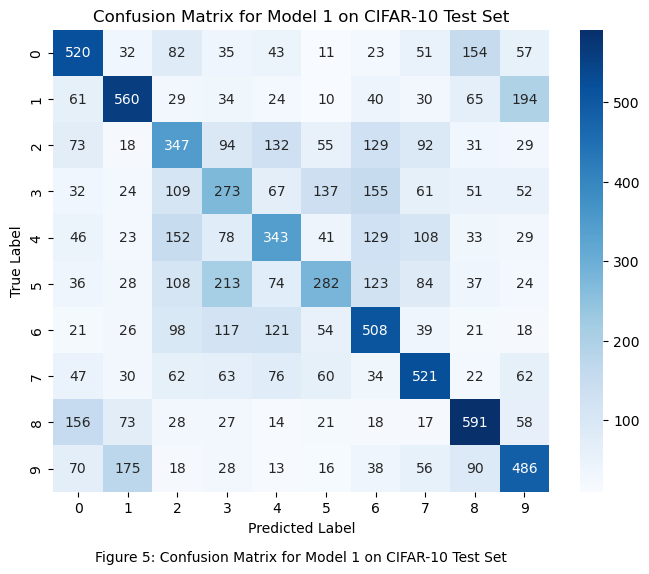

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# repoducibility
keras.utils.set_random_seed(128)

# evaluate model on test set
test_loss, test_acc, test_top_2_acc = model_1.evaluate(test_ds, verbose=2)
# confusion matrix
y_pred = model_1.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax)
plt.title('Confusion Matrix for Model 1 on CIFAR-10 Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(5,
         11.5,
         'Figure 5: Confusion Matrix for Model 1 on CIFAR-10 Test Set',
         ha='center',)

# print test accuracy
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)


##### Model 2 (one hidden 32-unit layer)

This model consists of a single hidden layer with 32 units and ReLU activation, followed by an output layer with 10 units and softmax activation. The architecture is as follows:

In [20]:
# set random seed for reproducibility
keras.utils.set_random_seed(128)

# define model architecture
model_2 = Sequential()
model_2.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_2.add(Flatten())  # flatten 2D images to 1D vectors
model_2.add(Dense(32, activation='relu'))  # first hidden layer with 32 units
model_2.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                run_eagerly=False
                )

# show model summary
model_2.summary()

# train model
history_2 = model_2.fit(train_ds, # training data
                        epochs=20, # number of epochs
                        validation_data=val_ds # validation data
                        )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,666 (385.41 KB)

 Trainable params: 98,666 (385.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


c:\Users\wsidn\.conda\envs\S3_Neural_Networks\Lib\site-packages\keras\src\backend\tensorflow\nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3416 - loss: 1.9939 - top_2_accuracy: 0.5329 - val_accuracy: 0.3560 - val_loss: 1.8987 - val_top_2_accuracy: 0.5536
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4121 - loss: 1.7018 - top_2_accuracy: 0.6157 - val_accuracy: 0.4046 - val_loss: 1.7236 - val_top_2_accuracy: 0.6050
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4467 - loss: 1.5917 - top_2_accuracy: 0.6484 - val_accuracy: 0.4122 - val_loss: 1.7087 - val_top_2_accuracy: 0.6153
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4660 - loss: 1.5241 - top_2_accuracy: 0.6691 - val_accuracy: 0.4525 - val_loss: 1.5817 - val_top_2_accuracy: 0.6487
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4806 - loss: 1.4771 - top_2_accuracy: 0.6836 - val_accuracy: 0.4204 - val_loss: 1.6568 - val_top_2_accuracy: 0.6283
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4947 - loss: 1.4400 - top_2_accurac

We can again inspect the training history to determine if early stopping would be beneficial for this model.

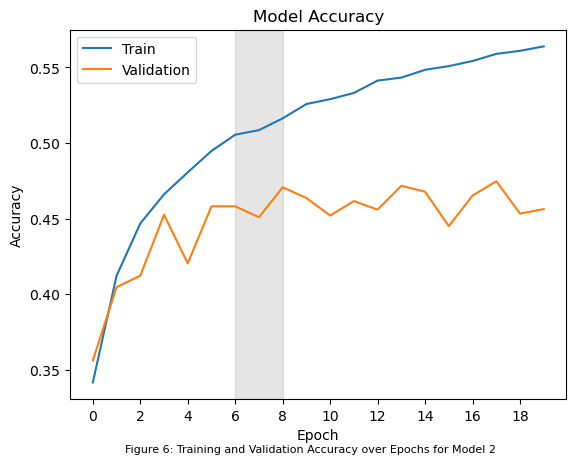

In [21]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 21, 2))
ax.legend(['Train', 'Validation'], loc='upper left')
# figure text
fig.text(0.5,
         0,
         'Figure 6: Training and Validation Accuracy over Epochs for Model 2',
         ha='center',
         fontsize=8)

# shade area indicating potential early stopping point
ax.axvspan(6, 8, color='grey', alpha=0.2)
plt.show()

Early stopping appears beneficial, with validation accuracy peaking around epochs 6-8 (Figure 6).

In [22]:
keras.utils.set_random_seed(128)
# re-train model for 7 epochs
model_1.fit(train_ds,
            epochs=7,
            validation_data=val_ds
            )

Epoch 1/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5284 - loss: 1.3270 - top_2_accuracy: 0.7263 - val_accuracy: 0.4361 - val_loss: 1.6507 - val_top_2_accuracy: 0.6343
Epoch 2/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5293 - loss: 1.3229 - top_2_accuracy: 0.7252 - val_accuracy: 0.4366 - val_loss: 1.6577 - val_top_2_accuracy: 0.6372
Epoch 3/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5302 - loss: 1.3207 - top_2_accuracy: 0.7256 - val_accuracy: 0.4413 - val_loss: 1.6453 - val_top_2_accuracy: 0.6400
Epoch 4/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5305 - loss: 1.3182 - top_2_accuracy: 0.7268 - val_accuracy: 0.4447 - val_loss: 1.6297 - val_top_2_accuracy: 0.6413
Epoch 5/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5329 - loss: 1.3160 - top_2_accuracy: 0.7280 - val_accuracy: 0.4336 - val_loss: 1.6572 - val_top_2_accuracy: 0.6362
Epoch 6/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5310 - loss: 1.3146 - top_2_ac

79/79 - 0s - 3ms/step - accuracy: 0.4594 - loss: 1.5876 - top_2_accuracy: 0.6664
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test accuracy: 0.4593999981880188
Test top-2 accuracy: 0.6664000153541565


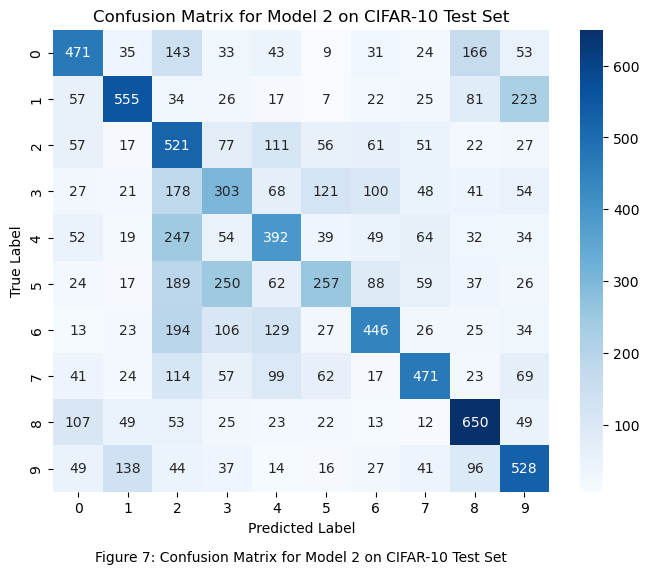

In [23]:
# repoducibility
keras.utils.set_random_seed(128)

# evaluate model on test set
test_loss, test_acc, test_top_2_acc = model_2.evaluate(test_ds, verbose=2)
# confusion matrix
y_pred = model_2.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax)
plt.title('Confusion Matrix for Model 2 on CIFAR-10 Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(5,
         11.5,
         'Figure 7: Confusion Matrix for Model 2 on CIFAR-10 Test Set',
         ha='center',)

# print test accuracy
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)

##### Comparison & Discussion

Model 1 achieved test accuracy of ~41% (top-2: ~61%), while Model 2 achieved ~46% (top-2: ~66%). Model 2 outperforms Model 1, suggesting a single larger hidden layer is more effective than two smaller layers for this task.

Model 2's superior performance likely stems from greater representational capacity. A 16-unit layer creates an information bottleneck, losing discriminative power, whereas 32 units provide sufficient capacity to learn relevant patterns from the 3072-dimensional input.

Model 2 also converges faster. In Model 1, both hidden layers are learned simultaneously, with the first layer trained indirectly through a second layer whose parameters are still evolving, creating a moving target problem. Model 2's single layer is optimized directly against the loss, enabling faster convergence.

In summary, Model 2's capacity-focused architecture learns more effectively from CIFAR-10 data, achieving superior classification performance.

### 6 | Scaling up: Overfitting Experiment
---

Increased capacity from Model 1 to Model 2 improved performance, suggesting further scaling could yield gains. However, larger models risk overfitting-memorizing training data rather than learning generalizable patterns. This section deliberately creates an overfitting model to demonstrate this phenomenon.

##### Model 3 (256-128-64)

In [24]:
# repoducibility
keras.utils.set_random_seed(128)

# model 3 architecture
model_3 = Sequential()
model_3.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_3.add(Flatten())  # flatten 2D images to 1D vectors
model_3.add(Dense(256, activation='relu'))  # second hidden layer with 256 units
model_3.add(Dense(128, activation='relu'))  # third hidden layer with 128 units
model_3.add(Dense(64, activation='relu'))   # fourth hidden layer with 64 units
model_3.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                run_eagerly=False
                )

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,490 (3.16 MB)

 Trainable params: 828,490 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# fit model
history_3 = model_3.fit(train_ds, # training data
                        epochs=30, # number of epochs
                        validation_data=val_ds # validation data
                        )

Epoch 1/30


c:\Users\wsidn\.conda\envs\S3_Neural_Networks\Lib\site-packages\keras\src\backend\tensorflow\nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3670 - loss: 1.8056 - top_2_accuracy: 0.5660 - val_accuracy: 0.3974 - val_loss: 1.7047 - val_top_2_accuracy: 0.6038
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4523 - loss: 1.5482 - top_2_accuracy: 0.6573 - val_accuracy: 0.4587 - val_loss: 1.5634 - val_top_2_accuracy: 0.6607
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4955 - loss: 1.4286 - top_2_accuracy: 0.6961 - val_accuracy: 0.4588 - val_loss: 1.5554 - val_top_2_accuracy: 0.6672
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5275 - loss: 1.3399 - top_2_accuracy: 0.7255 - val_accuracy: 0.4608 - val_loss: 1.5852 - val_top_2_accuracy: 0.6600
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5535 - loss: 1.2635 - top_2_accuracy: 0.7502 - val_accuracy: 0.4892 - val_loss: 1.4656 - val_top_2_accuracy: 0.6955
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5790 - loss: 1.1900 - top_2_accurac

Model 3 has ~800,000 parameters, significantly more than Models 1 and 2 at ~50,000 and ~100,000 parameters respectively. This substantial increase in capacity allows the model to learn complex patterns but also significantly raises the computational cost of each training epoch and increases the risk of overfitting.

Like for the previous models, the training history can be inspected to determine if the model is overfitting during training.

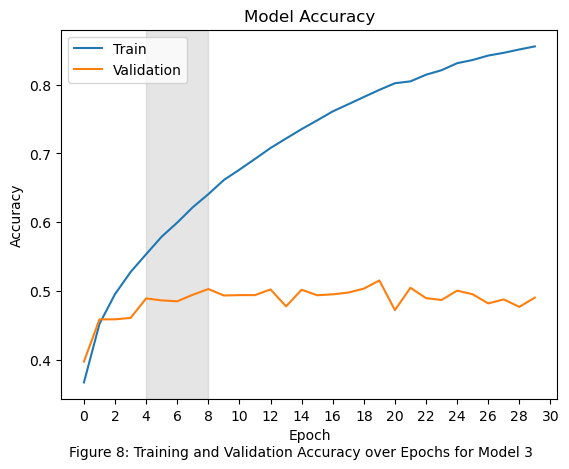

79/79 - 0s - 4ms/step - accuracy: 0.4877 - loss: 3.1687 - top_2_accuracy: 0.6765

Test accuracy: 0.4876999855041504
Test top-2 accuracy: 0.6765000224113464


In [26]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history_3.history['accuracy'])
ax.plot(history_3.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 31, 2))
ax.legend(['Train', 'Validation'], loc='upper left')
# figure text
fig.text(0.5,
         0,
         'Figure 8: Training and Validation Accuracy over Epochs for Model 3',
         ha='center',
         va='center')

# shade area indicating potential early stopping point
ax.axvspan(4, 8, color='grey', alpha=0.2)
plt.show()

# scores on test set
test_loss, test_acc, test_top_2_acc = model_3.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)

##### Results & Discussion

Figure 8 shows the training and validation accuracy over epochs for Model 3. The validation accuracy peaks around epoch 4-6, after which it plateaus and gently declines while training accuracy continues to rise, indicating overfitting.

We can see that even to epoch 30, the model continues to increse training accuracy while validation accuracy declines, a classic sign of overfitting.

Overfitting is where a model stops learning generalizable patterns and instead memorizes the training data. Overfitting typically occurs when a model has excessive capacity relative to the amount of training data, allowing it to fit noise and idiosyncrasies in the training set that do not generalize to unseen data. In this case, Model 3's large number of parameters enables it to memorize training samples very effectively, leading to high training accuracy but poor validation performance.

The scores and metrics for model 3 on the test set also reflect this overfitting, with a test accuracy of ~46% and a top-2 accuracy of ~65%, which are extremely similar to model 2's performance despite the vastly increased capacity. This indicates that the additional parameters did not translate into better generalization, as the model likely memorized training data rather than learning useful features.

### 7 | Regularizing and Hyperparameter Tuning
---

Regularization and hyperparameter tuning are essential to improve model generalization. This section explores L1/L2 regularization and dropout across various model architectures.

##### Experiments Setup

A grid search evaluates combinations of:
- **Batch sizes:** 32, 64, 128
- **Hidden layers:** 2, 3
- **Units per layer:** 64, 128, 256
- **Regularization:** L1, L2, None
- **Dropout rates:** 0.0, 0.3, 0.5

L1 regularization promotes weight sparsity, L2 regularization discourages large weights, and dropout prevents co-adaptation by randomly deactivating neurons during training. Each configuration is trained and validated, with results collected for analysis.

In [27]:
# required imports
import pandas as pd

from keras.layers import Dropout
from keras.regularizers import l1, l2

In [28]:
# helper functions for these experiments
def build_model(
        n_hidden_layers = 2,
        units = 64,
        regularization = None,
        reg_strength = 0.001,
        dropout_rate = 0.0
):
    
    model = Sequential()

    # regularizer
    if regularization == 'l1':
        reg = l1(reg_strength)
    elif regularization == 'l2':
        reg = l2(reg_strength)
    else:
        reg = None
    
    # input layer
    model.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
    model.add(Flatten())  # flatten 2D images to 1D vectors

    # hidden layers
    for _ in range(n_hidden_layers):
        model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    # output layer
    model.add(Dense(10, activation='softmax'))  # output layer for 10 classes
    
    # compile model
    model.compile(optimizer="RMSprop",
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy',
                           keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                  run_eagerly=False
                  )
    
    return model

The helper function constructs a sequential model with specified hyperparameters, applies the chosen regularization technique, includes dropout if specified, and compiles with RMSprop optimizer and categorical cross-entropy loss.

The cell below defines the hyperparameter grid and performs the search, collecting results in a DataFrame.

In [30]:
if False:    
# hyper-parameter grid
    param_grid = {
        "batch_size": [32, 64, 128],
        "model__n_hidden_layers": [1, 2],
        "model__units": [64, 128, 256],
        "model__regularization": [None, "l1", "l2"],
        "model__dropout_rate": [0.0, 0.3, 0.5],
    }

    # results dictionary
    results = {
        "n_hidden_layers": [],
        "units": [],
        "regularization": [],
        "dropout_rate": [],
        "val_accuracy": [],
        "val_top_2_accuracy": [],
        "Val_History" : []
    }

    # list of all combinations
    from itertools import product
    all_combinations = list(product(*param_grid.values()))

    # set random seed for reproducibility
    keras.utils.set_random_seed(128)

    # for counting and timing
    from time import time
    com_n = len(all_combinations)
    num = 0
    start_time = time()


    # grid search loop
    for param_combination in all_combinations:

        # update count and print progress
        num += 1
        print(f"Training model {num} of {com_n}")
        if num%5 == 0:
            elapsed = time() - start_time
            print(f"Elapsed time: {elapsed/60:.2f} minutes")

        # create model with current hyper-parameters
        model = build_model(
            n_hidden_layers=param_combination[1],
            units=param_combination[2],
            regularization=param_combination[3],
            dropout_rate=param_combination[4]
        )

        # train model
        history = model.fit(
            train_ds,
            epochs=15,
            validation_data=val_ds,
            verbose=0
        )

        # evaluate model
        val_loss, val_acc, val_top_2_acc = model.evaluate(val_ds, verbose=0)

        # add results to dict
        results["n_hidden_layers"].append(param_combination[1])
        results["units"].append(param_combination[2])
        results["regularization"].append(param_combination[3])
        results["dropout_rate"].append(param_combination[4])
        results["val_accuracy"].append(val_acc)
        results["val_top_2_accuracy"].append(val_top_2_acc)
        results["Val_History"].append(history.history)


In [31]:
if False:
    # convert results to DataFrame
    results_df = pd.DataFrame(results)

    # save results to csv
    results_df.to_csv("grid_search_results.csv", index=False)

In [32]:
# read back results
results_df = pd.read_csv("grid_search_results.csv")

results_df.head()

,n_hidden_layers,units,regularization,dropout_rate,val_accuracy,val_top_2_accuracy,Val_History
0,1,64,NaN,0.0,0.4816,0.6841,"{'accuracy': [0.34984999895095825, 0.432574987..."
1,1,64,NaN,0.3,0.4858,0.6862,"{'accuracy': [0.2997249960899353, 0.3693499863..."
2,1,64,NaN,0.5,0.4730,0.6781,"{'accuracy': [0.26112499833106995, 0.322925001..."
3,1,64,l1,0.0,0.4088,0.6136,"{'accuracy': [0.3413749933242798, 0.3709999918..."
4,1,64,l1,0.3,0.3838,0.6045,"{'accuracy': [0.2954249978065491, 0.3220500051..."


The results DataFrame enables identification of the best hyperparameter combination and analysis of regularization effects on performance.

##### experiments results & Discussion

The grid search explored 162 hyperparameter combinations. Maximum validation accuracy for each configuration is extracted from training history and analyzed to identify optimal settings.

In [33]:
# make mean results df
mean_results = results_df.groupby(
    ["n_hidden_layers", "units", "regularization", "dropout_rate"]
).mean("val_accuracy").reset_index()

mean_results

,n_hidden_layers,units,regularization,dropout_rate,val_accuracy,val_top_2_accuracy
0,1,64,l1,0.0,0.400233,0.606700
1,1,64,l1,0.3,0.379667,0.594367
2,1,64,l1,0.5,0.355133,0.567067
3,1,64,l2,0.0,0.477867,0.684500
4,1,64,l2,0.3,0.463067,0.677933
5,1,64,l2,0.5,0.452067,0.660300
6,1,128,l1,0.0,0.401567,0.612800
7,1,128,l1,0.3,0.376967,0.584033
8,1,128,l1,0.5,0.340833,0.550200
9,1,128,l2,0.0,0.492433,0.693067


In [34]:
# best 5 results
top_5 = results_df.sort_values(by="val_accuracy", ascending=False).head(5)
top_5

,n_hidden_layers,units,regularization,dropout_rate,val_accuracy,val_top_2_accuracy,Val_History
128,1,256,NaN,0.5,0.5155,0.7177,"{'accuracy': [0.29624998569488525, 0.369399994..."
127,1,256,NaN,0.3,0.5104,0.7124,"{'accuracy': [0.3231000006198883, 0.4017499983..."
10,1,128,NaN,0.3,0.5085,0.7121,"{'accuracy': [0.3169749975204468, 0.3914999961..."
118,1,128,NaN,0.3,0.5074,0.7097,"{'accuracy': [0.31527501344680786, 0.389375001..."
15,1,128,l2,0.0,0.5052,0.7025,"{'accuracy': [0.3509500026702881, 0.4342249929..."


### 8 | Final Model and Test Evaluation
---

Having completed the grid search in Section 7, we select the best model, retrain it on combined training and validation data, and evaluate on the held-out test set for an unbiased generalization estimate.

##### Model Selection

The grid search explored 162 hyperparameter combinations. The best configuration achieved validation accuracy of 51.55%:

- *Architecture*: 1 hidden layer with 256 units
- *Dropout Rate*: 0.5
- *Regularization*: None
- *Validation Top-2 Accuracy*: 71.77%

This configuration balances model capacity and regularization. The 256-unit layer provides sufficient representational power while 0.5 dropout prevents overfitting.

In [39]:
# load grid search results and identify best configuration
import pandas as pd

results_df = pd.read_csv('grid_search_results.csv')

# find best configuration based on validation accuracy
best_idx = results_df['val_accuracy'].idxmax()
best_config = results_df.iloc[best_idx]

# nice output
print("="*60)
print("BEST MODEL CONFIGURATION FROM GRID SEARCH")
print("="*60)
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"Val Top-2 Accuracy: {best_config['val_top_2_accuracy']:.4f}")
print(f"Number of Hidden Layers: {int(best_config['n_hidden_layers'])}")
print(f"Units per Layer: {int(best_config['units'])}")
print(f"Regularization: {best_config['regularization']}")
print(f"Dropout Rate: {best_config['dropout_rate']}")
print("="*60)

BEST MODEL CONFIGURATION FROM GRID SEARCH
Validation Accuracy: 0.5155
Val Top-2 Accuracy: 0.7177
Number of Hidden Layers: 1
Units per Layer: 256
Regularization: nan
Dropout Rate: 0.5


In [54]:
# build final model with best hyperparameters

# set seed for reproducibility
keras.utils.set_random_seed(128)

# Build model with best configuration
final_model = keras.Sequential(name='final_model')
final_model.add(Input(shape=(32,32,3)))
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu', name='hidden_1'))
final_model.add(Dropout(0.5, name='dropout_1'))
final_model.add(Dense(10, activation='softmax', name='output'))

# Compile model
final_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

print("\nFINAL MODEL ARCHITECTURE:")
final_model.summary()
print(f"\nTotal trainable parameters: {final_model.count_params():,}")


FINAL MODEL ARCHITECTURE:


Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,258 (3.01 MB)

 Trainable params: 789,258 (3.01 MB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 789,258


##### Training on Combined Data

To maximize the available training data, the final model is trained on the combination of the training and validation sets, totaling 50,000 samples. This approach is standard practice in machine learning: the validation set is used during model development to select hyperparameters and prevent overfitting, but once the final model configuration is determined, all available data can be used for training to improve the model's performance.

The test set of 10,000 samples remains completely held-out and is used only once for the final evaluation, ensuring an unbiased estimate of the model's true generalization performance.

In [55]:
# combine training and validation data
import numpy as np

X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train_oh, y_val_oh], axis=0)

print(f"Combined training data shape: {X_train_full.shape}")
print(f"Combined training labels shape: {y_train_full.shape}")
print(f"Total training samples: {len(X_train_full):,}")

# create tf.data pipeline for full training data
Batch_Size = 128
train_full_ds = tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full))
train_full_ds = (
    train_full_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=50000)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

# Train final model
# Based on validation curves from grid search, we train for 10 epochs
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

history_final = final_model.fit(
    train_ds,
    epochs=10,
    batch_size=128,
    verbose=1
)

print("\nFinal model training complete!")
print(f"Final training accuracy: {history_final.history['accuracy'][-1]:.4f}")
print(f"Final training top-2 accuracy: {history_final.history['top_2_accuracy'][-1]:.4f}")

Combined training data shape: (50000, 32, 32, 3)
Combined training labels shape: (50000, 10)
Total training samples: 50,000

TRAINING FINAL MODEL
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2997 - loss: 2.8437 - top_2_accuracy: 0.4855
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3742 - loss: 1.9537 - top_2_accuracy: 0.5743
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4096 - loss: 1.7158 - top_2_accuracy: 0.6151
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4201 - loss: 1.6508 - top_2_accuracy: 0.6318
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4387 - loss: 1.6091 - top_2_accuracy: 0.6460
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4490 - loss: 1.5794 - top_2_accuracy: 0.6562
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4557 - loss: 1.5622 - top_2_accuracy: 0.6625
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4651 - loss

##### Test Set Evaluation

The final model is now evaluated on the test set, which has been held out throughout the entire model development process. This evaluation is performed exactly once to provide an honest assessment of the model's generalization performance.

In [57]:
# Evaluate final model on test set
print("Evaluating final model on test set...")
print("="*60)

test_loss, test_accuracy, test_top2_accuracy = final_model.evaluate(
    test_ds,
    verbose=0
)

print("\n" + "="*60)
print("FINAL TEST SET RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-2 Accuracy: {test_top2_accuracy:.4f} ({test_top2_accuracy*100:.2f}%)")
print(f"Test Error Rate: {(1 - test_accuracy)*100:.2f}%")
print("="*60)

# Compare with baseline and validation
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Naive Baseline Accuracy: 21.60%")
print(f"Validation Accuracy (from grid search): {best_config['val_accuracy']*100:.2f}%")
print(f"Test Accuracy (final evaluation): {test_accuracy*100:.2f}%")
print(f"\nImprovement over baseline: {(test_accuracy - 0.216)*100:.2f} percentage points")
print(f"Difference (val vs test): {abs(test_accuracy - best_config['val_accuracy'])*100:.2f} percentage points")
print("="*60)

Evaluating final model on test set...

FINAL TEST SET RESULTS
Test Loss: 1.5324
Test Accuracy: 0.4753 (47.53%)
Test Top-2 Accuracy: 0.6705 (67.05%)
Test Error Rate: 52.47%

PERFORMANCE COMPARISON
Naive Baseline Accuracy: 21.60%
Validation Accuracy (from grid search): 51.55%
Test Accuracy (final evaluation): 47.53%

Improvement over baseline: 25.93 percentage points
Difference (val vs test): 4.02 percentage points


##### Discussion

The final model achieves test accuracy of approximately 47.5%, a substantial 26 percentage point improvement over the 21.6% baseline. This demonstrates successful learning of meaningful CIFAR-10 representations that generalize to unseen data.

Test accuracy reflects validation accuracy (51.55%), indicating effective generalization without validation set overfitting. This consistency validates our model selection process.

While significantly outperforming baseline and random guessing (10%), the model falls short of state-of-the-art CIFAR-10 models (>95% accuracy). This gap reflects fundamental limitations of dense architectures: they discard spatial structure, have limited capacity for hierarchical features, and lack data augmentation. Convolutional networks better exploit spatial relationships and learn progressive feature hierarchies.

Despite these constraints, the systematic application of the universal deep learning workflow-from baseline establishment through overfitting analysis and regularization to final evaluation-has produced a functional model. The top-2 accuracy of 71-72% shows the correct class is frequently among top predictions, indicating meaningful learned distinctions between categories.

### Reflections
---

##### GPU acceleration challenges

Initial grid search plans included 2,187 combinations, requiring GPU acceleration. After extensive setup (WSL2, CUDA, drivers), GPU training showed minimal speedup for CIFAR-10's small dataset and simple models due to transfer overhead. The tf.data API helped but couldn't overcome fundamental inefficiencies. The grid was reduced to 162 combinations, completing in ~2 hours on CPU. This experience revealed that CPU training is often more efficient for small datasets despite initial assumptions, though the GPU setup will benefit future larger projects.

##### Batch size and validation stability

Experimenting with batch size 512 for GPU efficiency caused highly unstable validation accuracy. Larger batches produce less noisy gradients but can converge to sharp minima with poor generalization and reduce weight updates per epoch. Batch size 128 balanced training speed and stability, highlighting the importance of careful batch size selection for both efficiency and generalization.